# PETITE

This runs a few simple tests on PETITE to make sure we reproduce the original physics 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from platform import python_version
print("Python version: ", python_version())

import numpy
print("Numpy version: ", numpy.__version__)

import os
current_path = os.getcwd()
PETITE_home_dir= current_path.split('examples')[0]

print("PETITE home directory:", PETITE_home_dir)

Python version:  3.11.8
Numpy version:  1.26.4
PETITE home directory: /Users/mhostert/Repos/PETITE/


### Load in dependencies and set font styles

In [66]:
from PETITE.dark_shower import *
from PETITE.shower import *
import pickle as pk
from matplotlib import pyplot as plt
from tqdm import tqdm
import matplotlib

from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FixedLocator, MaxNLocator
import cProfile
profile = cProfile.Profile()
import pstats

font0 = FontProperties()
font = font0.copy()
font.set_size(24)
font.set_family('serif')
labelfont=font0.copy()
labelfont.set_size(20)
labelfont.set_weight('bold')
legfont=font0.copy()
legfont.set_size(18)
legfont.set_weight('bold')


def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

def plot_shower(shower):
    photons = [p for p in shower if p.get_pid() == 22]
    electrons = [p for p in shower if p.get_pid() == 11]
    positrons = [p for p in shower if p.get_pid() == -11]
    print('Number of (photons, electrons, positrons): ', len(photons), len(electrons), len(positrons))

    # Let's look at the energy and angle spectra of all particles.
    # Let's make these plots in log-log scale, all particles go in the same plot, energy goes in the left panel, while angle goes in the right panel.
    
    E_min = np.min(np.concatenate([[p.get_p0()[0] for p in photons], [p.get_p0()[0] for p in electrons], [p.get_p0()[0] for p in positrons]]))
    E_max = np.max(np.concatenate([[p.get_p0()[0] for p in photons], [p.get_p0()[0] for p in electrons], [p.get_p0()[0] for p in positrons]]))
    
    angles = np.concatenate([[p.get_angle_to_z_0() for p in photons], [p.get_angle_to_z_0() for p in electrons], [p.get_angle_to_z_0() for p in positrons]])
    angle_min = np.min(angles[angles>0])
    angle_max = np.max(angles)
    
    
    bins_energy = np.geomspace(E_min, E_max, 20) # MeV
    bins_angle = np.geomspace(angle_min, angle_max, 20) # radians
    plt.figure(figsize=(12, 3))
    plt.subplot(121)
    plt.hist([p.get_p0()[0] for p in photons], bins=bins_energy, histtype='step', label='photons', ls=(1, (3,0)))
    plt.hist([p.get_p0()[0] for p in electrons], bins=bins_energy, histtype='step', label='electrons', ls=(1, (3,1)))
    plt.hist([p.get_p0()[0] for p in positrons], bins=bins_energy, histtype='step', label='positrons', ls=(1, (3,3)))
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Energy (GeV)')
    plt.ylabel('Number of particles')
    plt.legend()
    plt.subplot(122)
    plt.hist([p.get_angle_to_z_0() for p in photons], bins=bins_angle, histtype='step', label='photons', ls=(1, (3,0)))
    plt.hist([p.get_angle_to_z_0() for p in electrons], bins=bins_angle, histtype='step', label='electrons', ls=(1, (3,1)))
    plt.hist([p.get_angle_to_z_0() for p in positrons], bins=bins_angle, histtype='step', label='positrons', ls=(1, (3,3)))
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Angle to z-axis at production (rad)')
    plt.ylabel('Number of particles')
    plt.legend()
    plt.tight_layout()
    plt.show()
    

In [4]:
E0 = 1. # energy of incident particle in GeV
# Define incident electron
px, py, pz = 0, 0, np.sqrt(E0**2 - 0.000511**2)

# The crucial keys are 'PID' and 'ID', others are for efficient bookkeeping
particle_dict = {'PID': 11, 'ID':0, 'generation_number': 0, 'generation_process':'Input'}
p0 = Particle([E0, px, py, pz], [0,0,0], particle_dict)


In [54]:
def new_generate(shower, p0 = p0):
    return shower.generate_shower(p0, VB=False)

test_sgraphite = Shower(dict_dir=PETITE_home_dir+'MH_data/', target_material="graphite", min_energy=0.016, fast_MCS_mode=True, load_xsec_interp=True)
test_slead = Shower(dict_dir=PETITE_home_dir+'MH_data/', target_material="graphite", min_energy=0.016, fast_MCS_mode=True, load_xsec_interp=True)

original_sgraphite = Shower(dict_dir=PETITE_home_dir+'data/', target_material="graphite", min_energy=0.016, fast_MCS_mode=True, load_xsec_interp=False)
original_slead = Shower(dict_dir=PETITE_home_dir+'data/', target_material="graphite", min_energy=0.016, fast_MCS_mode=True, load_xsec_interp=False)

In [43]:
test_shower = new_generate(test_sgraphite)
original_shower = new_generate(original_sgraphite)

In [44]:
%%prun

# Let's see what the bottlenecks are now:

# Before, they were 1) quad, 2) interp1d, 3) __call__ for brem, 4) __call__ for pair production.

# Now it's the sampling of the shower development, which is expected.

for i in range(10):
    _ = new_generate(test_sgraphite)

         1404678 function calls (1404268 primitive calls) in 1.673 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      472    0.679    0.001    1.042    0.002 shower.py:635(draw_sample)
   156693    0.154    0.000    0.154    0.000 all_processes.py:175(__call__)
   203469    0.100    0.000    0.100    0.000 {built-in method numpy.array}
   178338    0.054    0.000    0.054    0.000 {method 'random' of 'numpy.random.mtrand.RandomState' objects}
     4743    0.054    0.000    0.228    0.000 moliere.py:404(get_scattered_momentum_fast)
      561    0.049    0.000    1.116    0.002 shower.py:718(sample_scattering)
     4743    0.047    0.000    0.056    0.000 moliere.py:338(get_rotation_matrix)
      570    0.037    0.000    0.504    0.001 shower.py:777(propagate_particle)
    20228    0.035    0.000    0.062    0.000 linalg.py:2383(norm)
      472    0.030    0.000    0.030    0.000 shower.py:652(<listcomp>)
    12182    0.02

In [45]:
from concurrent.futures import ThreadPoolExecutor

# Straight outta GPT
def parallel_shower(shower, n_iterations):
    def get_shower_wrapper():
        return new_generate(shower)
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(lambda _: get_shower_wrapper(), range(n_iterations)))
    return np.concatenate(results)

In [47]:
# Original map -- no xsec interpolators in this case
original_shower = parallel_shower(original_sgraphite, n_iterations=50)

# Test map -- uses xsec interpolators
test_shower = parallel_shower(test_sgraphite, n_iterations=50)

Number of (photons, electrons, positrons):  532 1776 592


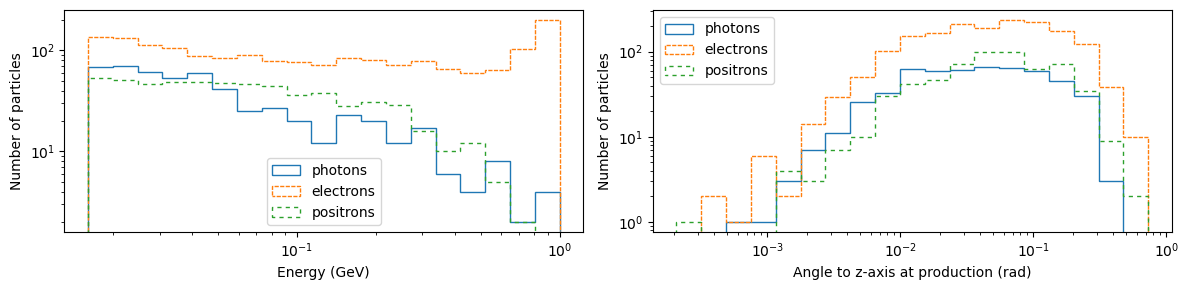

Number of (photons, electrons, positrons):  530 1885 536


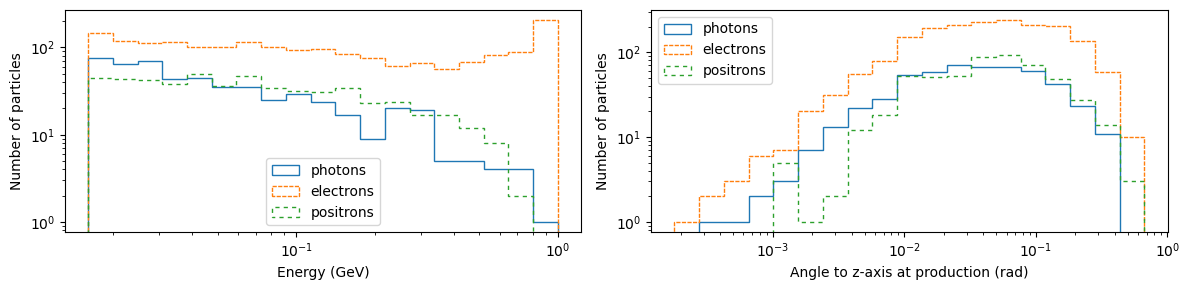

In [67]:
plot_shower(test_shower)
plot_shower(original_shower)

## Let's try to generate some high energy showers

In [81]:
E0 = 1e3
px, py, pz = 0, 0, np.sqrt(E0**2 - 0.000511**2)

# The crucial keys are 'PID' and 'ID', others are for efficient bookkeeping
particle_dict = {'PID': 11, 'ID':0, 'generation_number': 0, 'generation_process':'Input'}
p0_UHE = Particle([E0, px, py, pz], [0,0,0], particle_dict)


UHE_graphite = Shower(dict_dir=PETITE_home_dir+'MH_data/', target_material="graphite", min_energy=5, fast_MCS_mode=True, load_xsec_interp=True)

In [82]:
# %%prun
UHE_shower = new_generate(UHE_graphite, p0=p0_UHE)

Number of (photons, electrons, positrons):  94 631 601


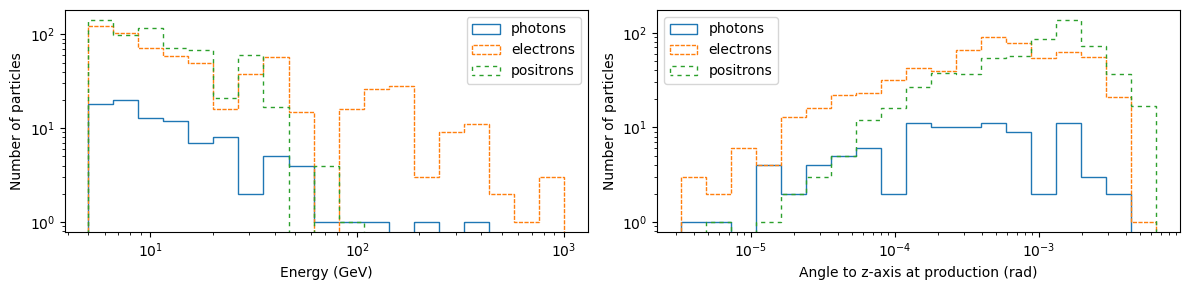

In [83]:
plot_shower(UHE_shower)

## Some other low-level checks

In [49]:
from PETITE.physical_constants import GeVsqcm2
from PETITE.targets import Target

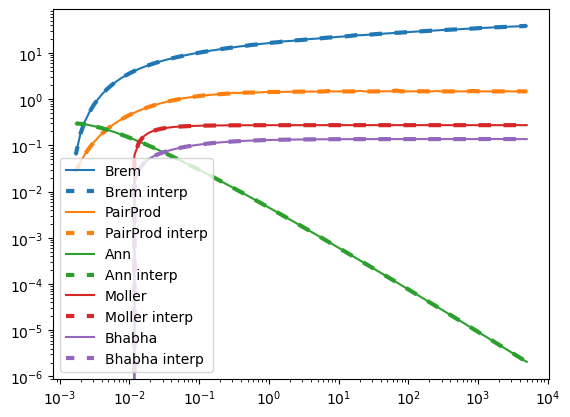

In [56]:

target = 'lead'

def plot_xsecs(label):
    E = np.geomspace(0.0017, 5e3, 101)

    cross_section_file = open('../MH_data/' + "sm_xsec.pkl", "rb")
    cross_section_dict = pickle.load(cross_section_file)
    xsec1 = interp1d(*np.array(cross_section_dict[label][target]).T)

    n = Target(target).get_n_target_for_process(label)
    c = plt.loglog(E, n*GeVsqcm2*xsec1(E), label=label)
        
    cross_section_file = open('../MH_data/' + "sm_xsec_interp.pkl", "rb")
    cross_section_dict = pickle.load(cross_section_file)
    xsec1 = cross_section_dict[label][target](E)
    plt.loglog(E, xsec1, label=label+' interp', color = c[0].get_color(), ls=(1, (3,)), lw=3)

plot_xsecs('Brem')
plot_xsecs('PairProd')
plot_xsecs('Ann')
plot_xsecs('Moller')
plot_xsecs('Bhabha')

plt.legend()

/var/folders/dl/ccbsfs591r1fhgcws28m8xy40000gn/T/ipykernel_4916/2105068553.py:13: RuntimeWarning: invalid value encountered in divide
  plt.semilogx(E, xsec1(E)/xsec0(E), label=label)


Text(0.5, 0, 'Energy (GeV)')

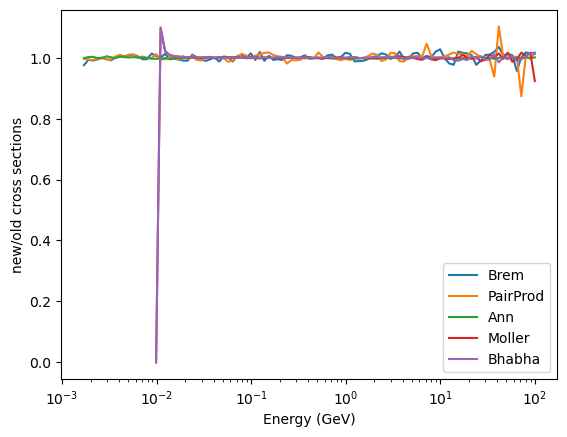

In [51]:
target = 'lead'

def plot_comparison(label):
    cross_section_file = open('../data/' + "sm_xsec.pkl", "rb")
    cross_section_dict = pickle.load(cross_section_file)
    xsec0 = interp1d(*np.array(cross_section_dict[label][target]).T)

    cross_section_file = open('../MH_data/' + "sm_xsec.pkl", "rb")
    cross_section_dict = pickle.load(cross_section_file)
    xsec1 = interp1d(*np.array(cross_section_dict[label][target]).T)

    E = np.geomspace(0.0017, 100, 101)
    plt.semilogx(E, xsec1(E)/xsec0(E), label=label)

plot_comparison('Brem')
plot_comparison('PairProd')
plot_comparison('Ann')
plot_comparison('Moller')
plot_comparison('Bhabha')

plt.legend()
plt.ylabel('new/old cross sections')
plt.xlabel('Energy (GeV)')

## New physics stuff (haven't touched yet)

#### Generate a DarkShower object with a dark vector mass of 30 MeV, tracking particle energies down to 30 MeV

The `DarkShower` class inherits from the `Shower` class. This means that instances of `DarkShower` can use the `generate_shower` method to produce a SM cascade if needed. `DarkShower` includes additional data and routines that enable the simulation of BSM particle production with a specific mass from a pre-calculated SM shower.

More options, for instance including only certain production modes of the BSM particle, are available as optional arguments when initializing the object.

In [5]:
sGraphite = DarkShower(PETITE_home_dir+dictionary_dir, "graphite", 0.030, 0.0323)

Weights not previously calculated, calculating now...


/Users/mhostert/Repos/PETITE/src/PETITE/shower.py:290: RuntimeWarning: divide by zero encountered in scalar power
  return cmtom*(self._NSigmaBrem(Energy) + self._NSigmaAnn(Energy) + self._NSigmaBhabha(Energy))**-1


dRate not previously calculated, calculating now...


The pre-saved VEGAS integrator objects have specific vector masses for training. By default, PETITE selects the nearest mass allowed below the provided one for simulation

In [6]:
print(sGraphite._mV_list)
print(sGraphite._mV)
print(sGraphite._mV_estimator)

[0.003, 0.01, 0.03, 0.1, 0.3, 1.0]
0.03
0.03


Samples are drawn for BSM production in the same approach as SM production in PETITE, using VEGAS-trained integrators at nearby energies for different physics process. Here is an example of simulating dark electron/positron bremsstrahlung of this 30 MeV particle.

In [8]:
Ebeam = 1.
ntrials = []
xs = []
for k in tqdm(range(30000)):
    # draw_dark_sample samples the "raw" kinematic variables that can be translated into particle momenta
    s0 = sGraphite.draw_dark_sample(Ebeam, process="DarkBrem", VB=True)
    xs.append([s0[0], s0[1]])
    # This saves the number of importance samples drawn before one was accepted - this can be used to diagnose the efficiency of sampling using nearby energies
    ntrials.append(s0[-1])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [00:54<00:00, 554.96it/s]


Plot the drawn distribution of $x_0$ (the proxy for the outgoing vector energy)

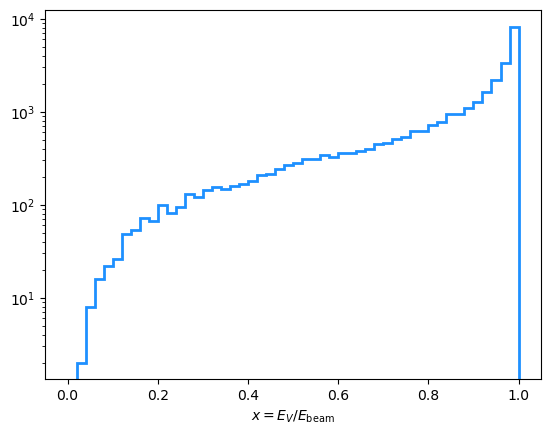

In [10]:
plt.hist(np.transpose(xs)[0], bins=np.linspace(0, 1, 51), histtype='step', lw=2, color='dodgerblue')
plt.xlabel(r'$x = E_V/E_{\mathrm{beam}}$')
plt.gca().set_yscale('log')

### Dark Shower Production

We now wish to simulate an ensemble of SM showers, each generated by a single 10 GeV photon hitting this graphite target. For each photon-on-target, the SM side of PETITE will generate a SM shower of particles, tracking down to our desired 30 MeV particle energy.

Then, PETITE uses `DarkShower` to take that list of SM particles and determine, for each one, the probability of emitting a 30 MeV vector boson $V$ through a number of different BSM processes (each one labelled by a different "generation_process" in the `Particle`'s `get_ids()` call). We will then inspect the resulting weighted distribution of these particles.

In [11]:
# Set up lists to organize data according to BSM process and parent particle
Energies, Weights, particles = {}, {}, {}
parent_pid_options = [11, -11, 22]
for pr in dark_process_codes:
    Energies[pr] = {}
    Weights[pr] = {}
    particles[pr] = {}
    for pid in parent_pid_options:
        Energies[pr][pid] = []
        Weights[pr][pid] = []
        particles[pr][pid] = []

In [12]:
n_photons_on_target = 30
for kk in tqdm(range(n_photons_on_target)):
    p0 = [10, 0, 0, 10]
    r0 = [0, 0, 0]
    pdict = {"PID":22, "weight":1.0/n_photons_on_target}
    part0 = Particle(p0, r0, pdict)
    s0SM = sGraphite.generate_shower(part0)
    s0BSM = sGraphite.generate_dark_shower(ExDir=list(s0SM));
    for p0 in s0BSM[1]:   
        genprocess = p0.get_ids()["generation_process"]
        parent_pid = p0.get_ids()["parent_PID"]

        Energies[genprocess][parent_pid].append(p0.get_p0()[0])
        Weights[genprocess][parent_pid].append(p0.get_ids()["weight"])
        particles[genprocess][parent_pid].append(p0)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:20<00:00,  2.68s/it]


(0.01, 10.0, 1e-06, 10.0)

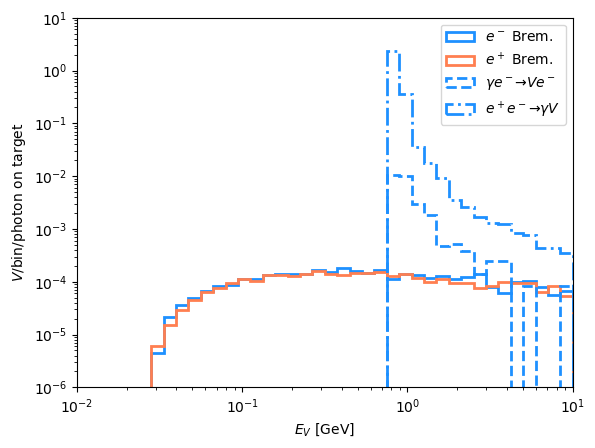

In [13]:
plt.hist(Energies['DarkBrem'][11], weights=Weights['DarkBrem'][11], bins=np.logspace(-2, 1, 41), histtype='step', lw=2, color='dodgerblue', label=r"$e^-\ \mathrm{Brem.}$")
plt.hist(Energies['DarkBrem'][-11], weights=Weights['DarkBrem'][-11], bins=np.logspace(-2, 1, 41), histtype='step', lw=2, color='coral', label=r"$e^+\ \mathrm{Brem.}$")
plt.hist(Energies['DarkComp'][22], weights=Weights['DarkComp'][22], bins=np.logspace(-2, 1, 41), histtype='step', lw=2, ls='--', color='dodgerblue', label=r"$\gamma e^- \to V e^-$")
plt.hist(Energies['DarkAnn'][-11], weights=Weights['DarkAnn'][-11], bins=np.logspace(-2, 1, 41), histtype='step', lw=2, ls='-.', color='dodgerblue', label=r"$e^+ e^- \to \gamma V$")
plt.legend(loc='best')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().set_xlabel(r"$E_V\ [\mathrm{GeV}]$")
plt.gca().set_ylabel(r"$V/\mathrm{bin}/\mathrm{photon\ on\ target}$")
plt.gca().axis([0.01, 10, 1e-6, 10])

This figure shows a histogram of all $V$ produced as a part of this process, but does not take into account the directional information of these particles. For instance, some distributions here may have a significantly larger off-axis component than others, yielding a different (relative) size of these histograms at a small solid-angle on-axis detector.

Let's imagine we have a detector situated 300 meters downstream of this photon beam, with a radius of 2.0 meters. We can now use the predefined "detector_cut()" function (in shower.py) to select out the BSM particles pointing towards the front face of this detector only.

(0.01, 10.0, 1e-06, 10.0)

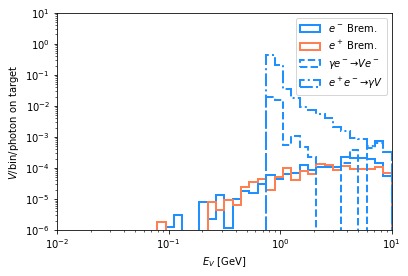

In [25]:
detector_distance = 300 # meters
detector_radius = 2.0 # meters

cut_particles_DarkBrem_electrons = detector_cut(particles['DarkBrem'][11], [detector_distance], detector_radius, method="Sample", energy_cut=None)[0]
energies = np.array([p.get_p0()[0] for p in cut_particles_DarkBrem_electrons])
weights = np.array([p.get_ids()["weight"] for p in cut_particles_DarkBrem_electrons])
plt.hist(energies, weights=weights, bins=np.logspace(-2, 1, 41), histtype='step', lw=2, color='dodgerblue', label=r"$e^-\ \mathrm{Brem.}$")

cut_particles_DarkBrem_positrons = detector_cut(particles['DarkBrem'][-11], [detector_distance], detector_radius, method="Sample", energy_cut=None)[0]
energies = np.array([p.get_p0()[0] for p in cut_particles_DarkBrem_positrons])
weights = np.array([p.get_ids()["weight"] for p in cut_particles_DarkBrem_positrons])
plt.hist(energies, weights=weights, bins=np.logspace(-2, 1, 41), histtype='step', lw=2, color='coral', label=r"$e^+\ \mathrm{Brem.}$")

cut_particles_DarkComp = detector_cut(particles['DarkComp'][22], [detector_distance], detector_radius, method="Sample", energy_cut=None)[0]
energies = np.array([p.get_p0()[0] for p in cut_particles_DarkComp])
weights = np.array([p.get_ids()["weight"] for p in cut_particles_DarkComp])
plt.hist(energies, weights=weights, bins=np.logspace(-2, 1, 41), histtype='step', lw=2, ls='--', color='dodgerblue', label=r"$\gamma e^- \to V e^-$")

cut_particles_DarkAnn = detector_cut(particles['DarkAnn'][-11], [detector_distance], detector_radius, method="Sample", energy_cut=None)[0]
energies = np.array([p.get_p0()[0] for p in cut_particles_DarkAnn])
weights = np.array([p.get_ids()["weight"] for p in cut_particles_DarkAnn])
plt.hist(energies, weights=weights, bins=np.logspace(-2, 1, 41), histtype='step', lw=2, ls='-.', color='dodgerblue', label=r"$e^+ e^- \to \gamma V$")

plt.legend(loc='best')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().set_xlabel(r"$E_V\ [\mathrm{GeV}]$")
plt.gca().set_ylabel(r"$V/\mathrm{bin}/\mathrm{photon\ on\ target}$")
plt.gca().axis([0.01, 10, 1e-6, 10])